In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical

data = pd.read_csv('processed_data/with_ranges_features.csv')
data['Time'] = pd.to_datetime(data['Time'], utc=True)
pd.set_option('display.max_rows', 500)

2024-06-23 12:09:38.648618: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-23 12:09:38.680369: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-23 12:09:38.680732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 12:09:39.215301: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
nr_values = 128
features = ['Elevation', 'Distance', 'HeartRateQuotient', 'HeartRateRange', 'Cadence', 'Speed', 'SpeedRange', 'SpeedQuotient', 'HeartRateClass']

In [3]:
runs = list(data.groupby("RunID"))
X = np.zeros((len(runs), nr_values, len(features)))
y = np.zeros((len(runs),))
for i, (name, group) in enumerate(runs):
    x_part = group[features].dropna()
    if len(x_part) < nr_values:
        continue

    last_30_seconds_data = group[group['Time'] >= group['Time'].max() - pd.Timedelta(seconds=30)]

    x_part["Distance"] = last_30_seconds_data['Distance'].max()

    X[i, :nr_values, :] = x_part.head(nr_values).to_numpy()
    y[i] = last_30_seconds_data['HeartRateClass'].mode().iloc[0]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
y = to_categorical(y, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
def evaluate_model(build_model):
    nr_epochs = 20
    histories = []
    for _ in range(10):
        model = build_model()
        history = model.fit(
            x_train, y_train,
            validation_data=(x_test, y_test),
            epochs=nr_epochs,
            batch_size = 10
        )
        histories.append(history)

    # Extract accuracy and loss from each history
    train_accuracies = np.array([history.history['accuracy'] for history in histories])
    val_accuracies = np.array([history.history['val_accuracy'] for history in histories])
    train_losses = np.array([history.history['loss'] for history in histories])
    val_losses = np.array([history.history['val_loss'] for history in histories])

    # Calculate mean and variance
    mean_train_accuracy = train_accuracies.mean(axis=0)
    std_train_accuracy = train_accuracies.std(axis=0)
    mean_val_accuracy = val_accuracies.mean(axis=0)
    std_val_accuracy = val_accuracies.std(axis=0)

    mean_train_loss = train_losses.mean(axis=0)
    std_train_loss = train_losses.std(axis=0)
    mean_val_loss = val_losses.mean(axis=0)
    std_val_loss = val_losses.std(axis=0)

    # Plot the mean and variance for accuracy and loss
    epochs = range(1, nr_epochs+1)

    plt.figure(figsize=(14, 6))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, mean_train_accuracy, 'b', label='Training accuracy')
    plt.fill_between(epochs, mean_train_accuracy - std_train_accuracy, mean_train_accuracy + std_train_accuracy, color='b', alpha=0.2)
    plt.plot(epochs, mean_val_accuracy, 'r', label='Validation accuracy')
    plt.fill_between(epochs, mean_val_accuracy - std_val_accuracy, mean_val_accuracy + std_val_accuracy, color='r', alpha=0.2)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mean_train_loss, 'b', label='Training loss')
    plt.fill_between(epochs, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, color='b', alpha=0.2)
    plt.plot(epochs, mean_val_loss, 'r', label='Validation loss')
    plt.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color='r', alpha=0.2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"model_{model.name}_eval.png")
    plt.show()
    

In [5]:
def build_lstm():
    model = keras.Sequential([
        keras.layers.LSTM(5, input_shape=(nr_values, len(features))),
        keras.layers.Dense(num_classes, activation="softmax"),
    ], name = "LSTM")
    model.compile(optimizer='adam', metrics=["accuracy"], loss="categorical_crossentropy")
    return model

model = build_lstm()
model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 300       
                                                                 
 dense (Dense)               (None, 7)                 42        
                                                                 
Total params: 342
Trainable params: 342
Non-trainable params: 0
_________________________________________________________________


2024-06-23 12:09:43.829609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:09:43.830630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:09:43.831443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2024-06-23 12:09:43.975703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:09:43.976668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:09:43.977365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-06-23 12:09:44.161247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:09:44.162228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:09:44.162989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 2s 25ms/step - loss: 1.7941 - accuracy: 0.1506 - val_loss: 1.7758 - val_accuracy: 0.1443
Epoch 2/20
 1/39 [..............................] - ETA: 0s - loss: 1.7821 - accuracy: 0.1000

2024-06-23 12:09:45.835790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:09:45.836791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:09:45.837543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 1s 17ms/step - loss: 1.7464 - accuracy: 0.1481 - val_loss: 1.7317 - val_accuracy: 0.1443
Epoch 3/20
39/39 [==============================] - 1s 17ms/step - loss: 1.7061 - accuracy: 0.2234 - val_loss: 1.6944 - val_accuracy: 0.3608
Epoch 4/20
39/39 [==============================] - 1s 17ms/step - loss: 1.6712 - accuracy: 0.3688 - val_loss: 1.6631 - val_accuracy: 0.3814
Epoch 5/20
39/39 [==============================] - 1s 18ms/step - loss: 1.6376 - accuracy: 0.3844 - val_loss: 1.6315 - val_accuracy: 0.3814
Epoch 6/20
39/39 [==============================] - 1s 17ms/step - loss: 1.6111 - accuracy: 0.3844 - val_loss: 1.6106 - val_accuracy: 0.3814
Epoch 7/20
39/39 [==============================] - 1s 18ms/step - loss: 1.5916 - accuracy: 0.3844 - val_loss: 1.5940 - val_accuracy: 0.3814
Epoch 8/20
39/39 [==============================] - 1s 19ms/step - loss: 1.5767 - accuracy: 0.3844 - val_loss: 1.5808 - val_accuracy: 0.3814
Epoch 9/20
39/39 [======

2024-06-23 12:09:59.078418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:09:59.079452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:09:59.080157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 2s 25ms/step - loss: 1.9618 - accuracy: 0.0519 - val_loss: 1.9341 - val_accuracy: 0.0515
Epoch 2/20
 1/39 [..............................] - ETA: 0s - loss: 1.9150 - accuracy: 0.1000

2024-06-23 12:10:00.940493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:10:00.941627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:10:00.942330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 1s 18ms/step - loss: 1.9195 - accuracy: 0.1273 - val_loss: 1.8951 - val_accuracy: 0.3814
Epoch 3/20
39/39 [==============================] - 1s 18ms/step - loss: 1.8778 - accuracy: 0.3844 - val_loss: 1.8527 - val_accuracy: 0.3814
Epoch 4/20
39/39 [==============================] - 1s 17ms/step - loss: 1.8343 - accuracy: 0.3844 - val_loss: 1.8153 - val_accuracy: 0.3814
Epoch 5/20
39/39 [==============================] - 1s 17ms/step - loss: 1.7994 - accuracy: 0.3844 - val_loss: 1.7829 - val_accuracy: 0.3814
Epoch 6/20
39/39 [==============================] - 1s 18ms/step - loss: 1.7691 - accuracy: 0.3844 - val_loss: 1.7560 - val_accuracy: 0.3814
Epoch 7/20
39/39 [==============================] - 1s 18ms/step - loss: 1.7426 - accuracy: 0.3844 - val_loss: 1.7324 - val_accuracy: 0.3814
Epoch 8/20
39/39 [==============================] - 1s 18ms/step - loss: 1.7197 - accuracy: 0.3844 - val_loss: 1.7106 - val_accuracy: 0.3814
Epoch 9/20
39/39 [======

2024-06-23 12:10:14.077920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:10:14.078997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:10:14.079701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 2s 25ms/step - loss: 1.9973 - accuracy: 0.1195 - val_loss: 1.9376 - val_accuracy: 0.1237
Epoch 2/20
 1/39 [..............................] - ETA: 0s - loss: 2.0073 - accuracy: 0.1000

2024-06-23 12:10:16.078643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:10:16.079974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:10:16.080727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 1s 18ms/step - loss: 1.9038 - accuracy: 0.2416 - val_loss: 1.8543 - val_accuracy: 0.3814
Epoch 3/20
39/39 [==============================] - 1s 17ms/step - loss: 1.8231 - accuracy: 0.3844 - val_loss: 1.7804 - val_accuracy: 0.3814
Epoch 4/20
39/39 [==============================] - 1s 18ms/step - loss: 1.7550 - accuracy: 0.3844 - val_loss: 1.7240 - val_accuracy: 0.3814
Epoch 5/20
39/39 [==============================] - 1s 17ms/step - loss: 1.7038 - accuracy: 0.3844 - val_loss: 1.6814 - val_accuracy: 0.3814
Epoch 6/20
39/39 [==============================] - 1s 17ms/step - loss: 1.6645 - accuracy: 0.3844 - val_loss: 1.6487 - val_accuracy: 0.3814
Epoch 7/20
39/39 [==============================] - 1s 17ms/step - loss: 1.6347 - accuracy: 0.3844 - val_loss: 1.6228 - val_accuracy: 0.3814
Epoch 8/20
39/39 [==============================] - 1s 18ms/step - loss: 1.6106 - accuracy: 0.3844 - val_loss: 1.6022 - val_accuracy: 0.3814
Epoch 9/20
39/39 [======

2024-06-23 12:10:29.392744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:10:29.393725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:10:29.394458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 2s 24ms/step - loss: 1.9389 - accuracy: 0.2701 - val_loss: 1.9099 - val_accuracy: 0.2680
Epoch 2/20
 1/39 [..............................] - ETA: 0s - loss: 1.8923 - accuracy: 0.3000

2024-06-23 12:10:31.226996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:10:31.227811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:10:31.228617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 1s 18ms/step - loss: 1.8905 - accuracy: 0.2701 - val_loss: 1.8657 - val_accuracy: 0.2680
Epoch 3/20
39/39 [==============================] - 1s 18ms/step - loss: 1.8460 - accuracy: 0.2779 - val_loss: 1.8220 - val_accuracy: 0.2887
Epoch 4/20
39/39 [==============================] - 1s 17ms/step - loss: 1.8016 - accuracy: 0.2935 - val_loss: 1.7795 - val_accuracy: 0.2887
Epoch 5/20
39/39 [==============================] - 1s 16ms/step - loss: 1.7620 - accuracy: 0.2935 - val_loss: 1.7447 - val_accuracy: 0.2887
Epoch 6/20
39/39 [==============================] - 1s 18ms/step - loss: 1.7285 - accuracy: 0.2935 - val_loss: 1.7154 - val_accuracy: 0.2887
Epoch 7/20
39/39 [==============================] - 1s 17ms/step - loss: 1.6989 - accuracy: 0.2935 - val_loss: 1.6883 - val_accuracy: 0.2887
Epoch 8/20
39/39 [==============================] - 1s 17ms/step - loss: 1.6735 - accuracy: 0.2935 - val_loss: 1.6642 - val_accuracy: 0.2887
Epoch 9/20
39/39 [======

2024-06-23 12:10:44.414466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:10:44.415480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:10:44.416313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 2s 24ms/step - loss: 1.9354 - accuracy: 0.3506 - val_loss: 1.9242 - val_accuracy: 0.3608
Epoch 2/20
 1/39 [..............................] - ETA: 0s - loss: 1.9328 - accuracy: 0.4000

2024-06-23 12:10:46.261948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:10:46.262928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:10:46.263676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 1s 18ms/step - loss: 1.9133 - accuracy: 0.3610 - val_loss: 1.9022 - val_accuracy: 0.3608
Epoch 3/20
39/39 [==============================] - 1s 17ms/step - loss: 1.8907 - accuracy: 0.3636 - val_loss: 1.8783 - val_accuracy: 0.3814
Epoch 4/20
39/39 [==============================] - 1s 18ms/step - loss: 1.8622 - accuracy: 0.3844 - val_loss: 1.8490 - val_accuracy: 0.3814
Epoch 5/20
39/39 [==============================] - 1s 17ms/step - loss: 1.8335 - accuracy: 0.3844 - val_loss: 1.8253 - val_accuracy: 0.3814
Epoch 6/20
39/39 [==============================] - 1s 18ms/step - loss: 1.8113 - accuracy: 0.3844 - val_loss: 1.8049 - val_accuracy: 0.3814
Epoch 7/20
39/39 [==============================] - 1s 18ms/step - loss: 1.7915 - accuracy: 0.3844 - val_loss: 1.7869 - val_accuracy: 0.3814
Epoch 8/20
39/39 [==============================] - 1s 18ms/step - loss: 1.7735 - accuracy: 0.3844 - val_loss: 1.7698 - val_accuracy: 0.3814
Epoch 9/20
39/39 [======

2024-06-23 12:10:59.546445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:10:59.547586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:10:59.548292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 2s 25ms/step - loss: 2.1784 - accuracy: 0.0338 - val_loss: 2.1495 - val_accuracy: 0.0309
Epoch 2/20
 1/39 [..............................] - ETA: 0s - loss: 2.0261 - accuracy: 0.1000

2024-06-23 12:11:01.523087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:11:01.524178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:11:01.524881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 1s 18ms/step - loss: 2.1197 - accuracy: 0.0338 - val_loss: 2.0941 - val_accuracy: 0.0309
Epoch 3/20
39/39 [==============================] - 1s 17ms/step - loss: 2.0655 - accuracy: 0.0338 - val_loss: 2.0404 - val_accuracy: 0.0309
Epoch 4/20
39/39 [==============================] - 1s 18ms/step - loss: 2.0126 - accuracy: 0.0338 - val_loss: 1.9896 - val_accuracy: 0.0309
Epoch 5/20
39/39 [==============================] - 1s 17ms/step - loss: 1.9603 - accuracy: 0.1896 - val_loss: 1.9397 - val_accuracy: 0.2887
Epoch 6/20
39/39 [==============================] - 1s 17ms/step - loss: 1.9114 - accuracy: 0.2935 - val_loss: 1.8944 - val_accuracy: 0.2887
Epoch 7/20
39/39 [==============================] - 1s 17ms/step - loss: 1.8685 - accuracy: 0.2935 - val_loss: 1.8571 - val_accuracy: 0.2887
Epoch 8/20
39/39 [==============================] - 1s 17ms/step - loss: 1.8325 - accuracy: 0.2935 - val_loss: 1.8238 - val_accuracy: 0.2887
Epoch 9/20
39/39 [======

2024-06-23 12:11:14.892458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:11:14.893536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:11:14.894246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 2s 25ms/step - loss: 1.9161 - accuracy: 0.0390 - val_loss: 1.8937 - val_accuracy: 0.0309
Epoch 2/20
 1/39 [..............................] - ETA: 0s - loss: 1.9827 - accuracy: 0.0000e+00

2024-06-23 12:11:16.819015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:11:16.820184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:11:16.821078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 1s 18ms/step - loss: 1.8711 - accuracy: 0.2779 - val_loss: 1.8504 - val_accuracy: 0.3814
Epoch 3/20
39/39 [==============================] - 1s 18ms/step - loss: 1.8286 - accuracy: 0.3844 - val_loss: 1.8098 - val_accuracy: 0.3814
Epoch 4/20
39/39 [==============================] - 1s 17ms/step - loss: 1.7892 - accuracy: 0.3844 - val_loss: 1.7729 - val_accuracy: 0.3814
Epoch 5/20
39/39 [==============================] - 1s 17ms/step - loss: 1.7525 - accuracy: 0.3844 - val_loss: 1.7405 - val_accuracy: 0.3814
Epoch 6/20
39/39 [==============================] - 1s 18ms/step - loss: 1.7215 - accuracy: 0.3844 - val_loss: 1.7133 - val_accuracy: 0.3814
Epoch 7/20
39/39 [==============================] - 1s 18ms/step - loss: 1.6955 - accuracy: 0.3844 - val_loss: 1.6895 - val_accuracy: 0.3814
Epoch 8/20
39/39 [==============================] - 1s 18ms/step - loss: 1.6728 - accuracy: 0.3844 - val_loss: 1.6693 - val_accuracy: 0.3814
Epoch 9/20
39/39 [======

2024-06-23 12:11:30.335901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:11:30.337093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:11:30.337861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 2s 25ms/step - loss: 1.9736 - accuracy: 0.0468 - val_loss: 1.9387 - val_accuracy: 0.3608
Epoch 2/20
 1/39 [..............................] - ETA: 0s - loss: 1.9143 - accuracy: 0.4000

2024-06-23 12:11:32.243684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:11:32.244669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:11:32.245370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 1s 19ms/step - loss: 1.9113 - accuracy: 0.3610 - val_loss: 1.8817 - val_accuracy: 0.3608
Epoch 3/20
39/39 [==============================] - 1s 18ms/step - loss: 1.8563 - accuracy: 0.3610 - val_loss: 1.8302 - val_accuracy: 0.3814
Epoch 4/20
39/39 [==============================] - 1s 18ms/step - loss: 1.8055 - accuracy: 0.3844 - val_loss: 1.7820 - val_accuracy: 0.3814
Epoch 5/20
39/39 [==============================] - 1s 17ms/step - loss: 1.7606 - accuracy: 0.3844 - val_loss: 1.7447 - val_accuracy: 0.3814
Epoch 6/20
39/39 [==============================] - 1s 17ms/step - loss: 1.7246 - accuracy: 0.3844 - val_loss: 1.7117 - val_accuracy: 0.3814
Epoch 7/20
39/39 [==============================] - 1s 18ms/step - loss: 1.6936 - accuracy: 0.3844 - val_loss: 1.6851 - val_accuracy: 0.3814
Epoch 8/20
39/39 [==============================] - 1s 17ms/step - loss: 1.6672 - accuracy: 0.3844 - val_loss: 1.6619 - val_accuracy: 0.3814
Epoch 9/20
39/39 [======

2024-06-23 12:11:45.549110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:11:45.550061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:11:45.550737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 2s 25ms/step - loss: 1.8087 - accuracy: 0.1195 - val_loss: 1.7829 - val_accuracy: 0.1237
Epoch 2/20
 1/39 [..............................] - ETA: 0s - loss: 1.8998 - accuracy: 0.1000

2024-06-23 12:11:47.416734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:11:47.417722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:11:47.418450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 1s 18ms/step - loss: 1.7624 - accuracy: 0.2416 - val_loss: 1.7413 - val_accuracy: 0.3814
Epoch 3/20
39/39 [==============================] - 1s 18ms/step - loss: 1.7217 - accuracy: 0.3844 - val_loss: 1.7038 - val_accuracy: 0.3814
Epoch 4/20
39/39 [==============================] - 1s 17ms/step - loss: 1.6847 - accuracy: 0.3844 - val_loss: 1.6737 - val_accuracy: 0.3814
Epoch 5/20
39/39 [==============================] - 1s 18ms/step - loss: 1.6550 - accuracy: 0.3844 - val_loss: 1.6466 - val_accuracy: 0.3814
Epoch 6/20
39/39 [==============================] - 1s 17ms/step - loss: 1.6314 - accuracy: 0.3844 - val_loss: 1.6256 - val_accuracy: 0.3814
Epoch 7/20
39/39 [==============================] - 1s 18ms/step - loss: 1.6117 - accuracy: 0.3844 - val_loss: 1.6098 - val_accuracy: 0.3814
Epoch 8/20
39/39 [==============================] - 1s 18ms/step - loss: 1.5959 - accuracy: 0.3844 - val_loss: 1.5961 - val_accuracy: 0.3814
Epoch 9/20
39/39 [======

2024-06-23 12:12:00.755378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:12:00.756186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:12:00.757006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 2s 24ms/step - loss: 1.9847 - accuracy: 0.1221 - val_loss: 1.9630 - val_accuracy: 0.1237
Epoch 2/20
 1/39 [..............................] - ETA: 0s - loss: 1.9560 - accuracy: 0.1000

2024-06-23 12:12:02.608452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 12:12:02.609364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 12:12:02.610188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 1s 17ms/step - loss: 1.9357 - accuracy: 0.1325 - val_loss: 1.9157 - val_accuracy: 0.1443
Epoch 3/20
39/39 [==============================] - 1s 17ms/step - loss: 1.8855 - accuracy: 0.1481 - val_loss: 1.8670 - val_accuracy: 0.1443
Epoch 4/20
39/39 [==============================] - 1s 17ms/step - loss: 1.8388 - accuracy: 0.2156 - val_loss: 1.8257 - val_accuracy: 0.3814
Epoch 5/20
39/39 [==============================] - 1s 18ms/step - loss: 1.8013 - accuracy: 0.3896 - val_loss: 1.7907 - val_accuracy: 0.3814
Epoch 6/20
39/39 [==============================] - 1s 18ms/step - loss: 1.7676 - accuracy: 0.3896 - val_loss: 1.7613 - val_accuracy: 0.3814
Epoch 7/20
39/39 [==============================] - 1s 17ms/step - loss: 1.7386 - accuracy: 0.3896 - val_loss: 1.7343 - val_accuracy: 0.3814
Epoch 8/20
39/39 [==============================] - 1s 17ms/step - loss: 1.7128 - accuracy: 0.3896 - val_loss: 1.7107 - val_accuracy: 0.3814
Epoch 9/20
39/39 [======

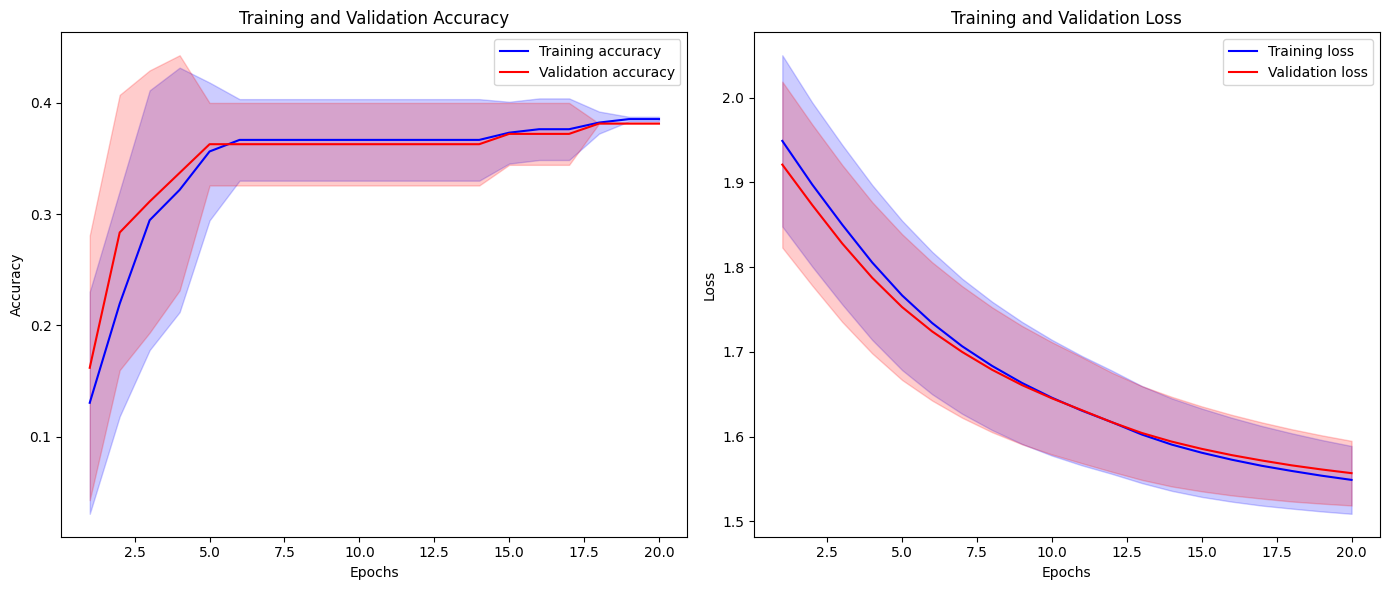

In [6]:
evaluate_model(build_lstm)

In [7]:
from tcn import TCN

def build_tcn():
    model = keras.Sequential([
        keras.layers.Input(shape=(nr_values, len(features))),
        TCN(
            nb_filters=5,
            kernel_size=3,
            dilations=[2**i for i in range(5)],
            nb_stacks=1,
        ),
        keras.layers.Dense(num_classes, activation='softmax')
    ], name="TCN")
    model.compile(optimizer='adam', metrics=["accuracy"], loss="categorical_crossentropy")
    return model

model = build_tcn()
model.summary()

Model: "TCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 5)                 910       
                                                                 
 dense_11 (Dense)            (None, 7)                 42        
                                                                 
Total params: 952
Trainable params: 952
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
39/39 [==============================] - 2s 10ms/step - loss: 7288.4771 - accuracy: 0.2753 - val_loss: 6363.5820 - val_accuracy: 0.0206
Epoch 2/20
39/39 [==============================] - 0s 5ms/step - loss: 4618.4243 - accuracy: 0.2727 - val_loss: 4241.3018 - val_accuracy: 0.3814
Epoch 3/20
39/39 [==============================] - 0s 4ms/step - loss: 2935.3462 - accuracy: 0.2961 - val_loss: 2600.8269 - val_accuracy: 0.3814
Epoch 4/20
39/39 [==============================] - 0s 4ms/step - loss: 1646.1798 - accuracy: 0.3299 - val_loss: 1632.7682 - val_accuracy: 0.2784
Epoch 5/20
39/39 [==============================] - 0s 4ms/step - loss: 1179.8680 - accuracy: 0.3065 - val_loss: 1297.4424 - val_accuracy: 0.4124
Epoch 6/20
39/39 [==============================] - 0s 4ms/step - loss: 953.4518 - accuracy: 0.3039 - val_loss: 1071.5334 - val_accuracy: 0.3299
Epoch 7/20
39/39 [==============================] - 0s 4ms/step - loss: 794.5583 - accuracy: 0.2987 - val_loss: 880.4412 - v

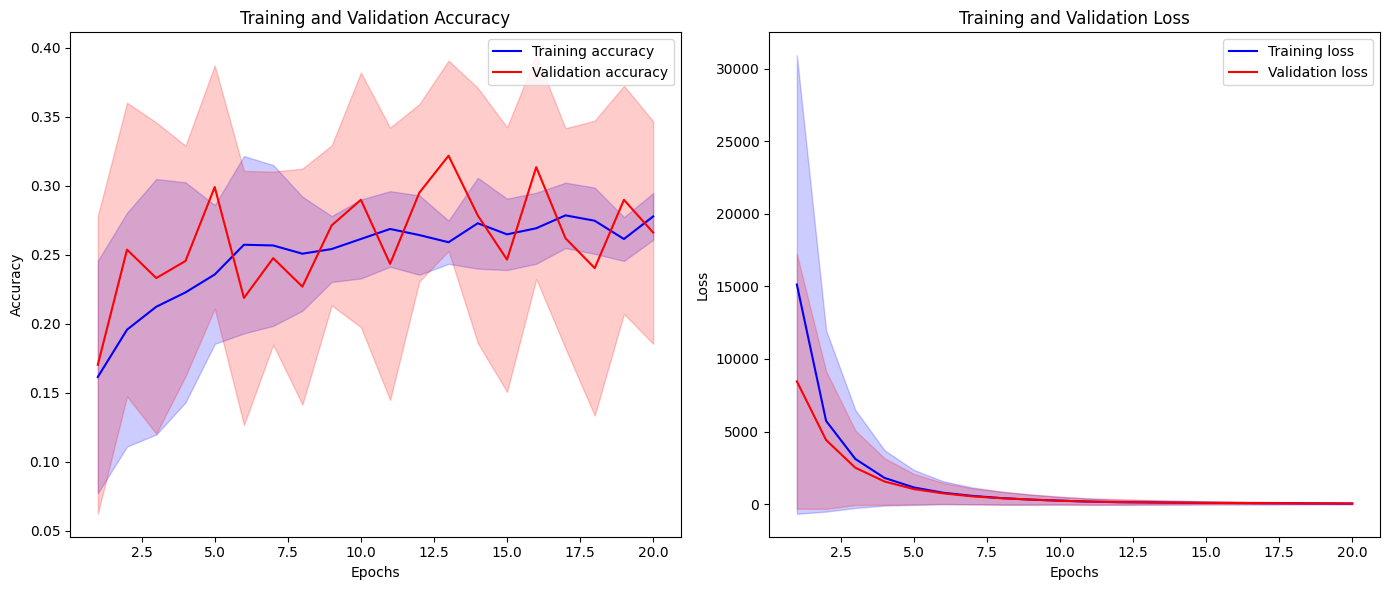

In [8]:
evaluate_model(build_tcn)